# Analysis help

This covers stuff that you will need to know in order to use the `committor_results.nc` file.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths
import numpy as np
import pandas as pd
pd.options.display.max_rows = 10

In [2]:
storage = paths.Storage("committor_results.nc", "r")

In [3]:
phi = storage.cvs['phi']
psi = storage.cvs['psi']

In [4]:
%%time
C_7eq = storage.volumes['C_7eq']
alpha_R = storage.volumes['alpha_R']
experiments = storage.tag['experiments']

CPU times: user 49.6 s, sys: 239 ms, total: 49.8 s
Wall time: 51.4 s


The `experiments` object is a list of tuples `(snapshot, final_state)`. Each `snapshot` is an OPS snapshot object (a point in phase space), and the `final_state` is either the `C_7eq` object or the `alpha_R` object.

## Directly obtaining a committor analysis

As it happens, `experiments` is in precisely the correct format to be used in one of the approaches to constructing a committor analysis.

This section requires OpenPathSampling 0.9.1 or later.

In [5]:
%%time
committor_analyzer = paths.ShootingPointAnalysis.from_individual_runs(experiments)

CPU times: user 44 s, sys: 143 ms, total: 44.2 s
Wall time: 49.1 s


Before going further, let's talk a little bit about the implementation of the `ShootingPointAnalysis` object. The main thing to understand is that the purpose of that object is to histogram according to configuration. The first snapshot encountered is kept as a representative of that configuration.

So whereas there are 10000 snapshots in `experiments` (containing the full data, including velocities), there are only 1000 entries in the `committor_analyzer` (because, in this data set, I ran 1000 snapshots with 10 shots each.)

### Per-configuration results

The `.to_pandas()` function creates a pandas table with configurations as the index, the final states as columns, and the number of times that configuration led to that final state as entries. With no argument, `to_pandas()` using the an integer for each configuration.

In [6]:
committor_analyzer.to_pandas()

,C_7eq,alpha_R
0,8.0,2.0
1,5.0,5.0
2,9.0,1.0
3,9.0,1.0
4,10.0,NaN
...,...,...
995,3.0,7.0
996,4.0,6.0
997,9.0,1.0
998,8.0,2.0


You can also pass it a function that takes a snapshot and returns a (hashable) value. That value will be used for the index. These collective variables return numpy arrays, so we need to cast the 1D array to a `float`.

In [7]:
psi_hash = lambda x : float(psi(x))
committor_analyzer.to_pandas(label_function=psi_hash)

,C_7eq,alpha_R
0.824873,8.0,2.0
0.576733,5.0,5.0
0.521896,9.0,1.0
0.444523,9.0,1.0
0.977096,10.0,NaN
...,...,...
0.419521,3.0,7.0
0.353020,4.0,6.0
1.492791,9.0,1.0
1.054834,8.0,2.0


You can also directly obtain the committor as a dictionary of (representative) snapshot to committor value. The committor here is defines as the probability of ending in a given state, so you must give the state.

In [8]:
committor = committor_analyzer.committor(alpha_R)

In [9]:
# show the first 10 values
{k: committor[k] for k in committor.keys()[:10]}

{<openpathsampling.engines.openmm.snapshot.Snapshot at 0x10f116b90>: 0.0,
 <openpathsampling.engines.openmm.snapshot.Snapshot at 0x10f192f50>: 0.4,
 <openpathsampling.engines.openmm.snapshot.Snapshot at 0x10f31a990>: 0.0,
 <openpathsampling.engines.openmm.snapshot.Snapshot at 0x10f34ef10>: 0.3,
 <openpathsampling.engines.openmm.snapshot.Snapshot at 0x10f5c13d0>: 0.3,
 <openpathsampling.engines.openmm.snapshot.Snapshot at 0x10f9e1950>: 0.0,
 <openpathsampling.engines.openmm.snapshot.Snapshot at 0x10fd170d0>: 0.3,
 <openpathsampling.engines.openmm.snapshot.Snapshot at 0x1100f4c50>: 0.1,
 <openpathsampling.engines.openmm.snapshot.Snapshot at 0x1101f7410>: 0.2,
 <openpathsampling.engines.openmm.snapshot.Snapshot at 0x1103bd390>: 0.0}

### Committor histogram in 1D

In [10]:
hist1D, bins = committor_analyzer.committor_histogram(psi_hash, alpha_R, bins=20)

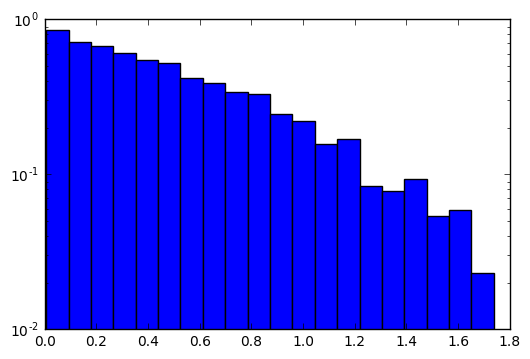

In [11]:
bin_widths = [bins[i+1]-bins[i] for i in range(len(bins)-1)]
plt.bar(left=bins[:-1], height=hist1D, width=bin_widths, log=True);

### Committor histogram in 2D

In [12]:
ramachandran_hash = lambda x : (float(phi(x)), float(psi(x)))
hist2D, bins_phi, bins_psi = committor_analyzer.committor_histogram(ramachandran_hash, alpha_R, bins=20)

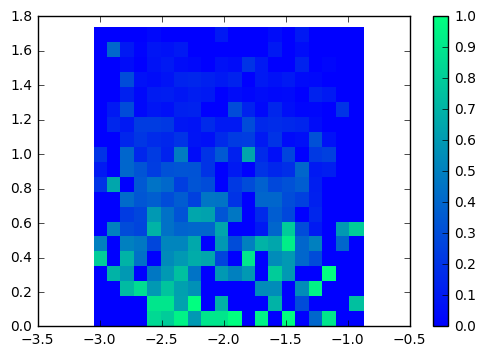

In [13]:
# not the best, since it doesn't distinguish NaNs, but that's just a matter of plotting
plt.pcolor(bins_phi, bins_psi, hist2D.T, cmap="winter")
plt.clim(0.0, 1.0)
plt.colorbar();

## Obtaining information from the snapshots

The information `committor_results.nc` should be *everything* you could want, including initial velocities for every system. In principle, you'll mainly access that information using collective variables (see documentation on using MDTraj to create OPS collective variables). However, you may decide to access that information directly, so here's how you do that.

In [14]:
# let's take the first shooting point snapshot
# experiments[N][0] gives shooting snapshot for experiment N
snapshot = experiments[0][0]

OpenMM-based objects come with units. So `snapshot.coordinates` is a unitted value. This can be annoying in analysis, so we have a convenience `snapshot.xyz` to get the version without units.

In [15]:
snapshot.coordinates

Quantity(value=array([[ 0.2793301 , -0.12214785, -0.202672  ],
       [ 0.2449614 , -0.05111128, -0.1274817 ],
       [ 0.33534443, -0.01180077, -0.08093405],
       ..., 
       [-1.46748817, -0.68787634,  0.40931037],
       [-1.55375791, -0.72757316,  0.42131069],
       [-1.45325804, -0.68954408,  0.31466872]], dtype=float32), unit=nanometer)

In [16]:
snapshot.xyz

array([[ 0.2793301 , -0.12214785, -0.202672  ],
       [ 0.2449614 , -0.05111128, -0.1274817 ],
       [ 0.33534443, -0.01180077, -0.08093405],
       ..., 
       [-1.46748817, -0.68787634,  0.40931037],
       [-1.55375791, -0.72757316,  0.42131069],
       [-1.45325804, -0.68954408,  0.31466872]], dtype=float32)

For velocities, we don't have the convenience function, but if you want to remove units from velocities you can do so with `velocity / velocity.unit`.

In [17]:
snapshot.velocities

Quantity(value=array([[ -3.21658134e-01,  -1.10456896e+00,   7.57985592e-01],
       [ -2.63174623e-01,   7.86199495e-02,  -5.87066524e-02],
       [ -4.26795304e-01,   3.19573097e-03,  -2.02318802e-01],
       ..., 
       [  2.87866861e-01,   5.24361193e-01,   2.04794154e-01],
       [ -3.03164870e-01,   3.03924894e+00,  -1.35492578e-01],
       [ -1.56592965e+00,  -4.29962158e+00,  -5.62753141e-01]], dtype=float32), unit=nanometer/picosecond)

In [18]:
snapshot.velocities / snapshot.velocities.unit

array([[ -3.21658134e-01,  -1.10456896e+00,   7.57985592e-01],
       [ -2.63174623e-01,   7.86199495e-02,  -5.87066524e-02],
       [ -4.26795304e-01,   3.19573097e-03,  -2.02318802e-01],
       ..., 
       [  2.87866861e-01,   5.24361193e-01,   2.04794154e-01],
       [ -3.03164870e-01,   3.03924894e+00,  -1.35492578e-01],
       [ -1.56592965e+00,  -4.29962158e+00,  -5.62753141e-01]], dtype=float32)

Note that snapshots include coordinates and velocities. We have several sets of initial velocities for each initial snapshot. Taking the second shooting snapshot and comparing coordinates and velocities:

In [19]:
snapshot2 = experiments[1][0]

In [20]:
np.all(snapshot.coordinates == snapshot2.coordinates)

True

In [21]:
np.any(snapshot.velocities == snapshot2.velocities)

False